In [29]:
import numpy as np
import torch
import torch.nn as nn
from torchaudio import transforms
from scipy import signal
from matplotlib import pyplot as plt
from PIL import Image
#from joblib import Parallel, delayed  #multithreading 

In [30]:
# Verificar si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Definir el dispositivo a utilizar (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if cuda_available else "cpu")

In [31]:
# Definir una red neuronal simple
class Model_qm(nn.Module):
    def __init__(self):
        super(Model_qm, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [32]:
q_m_XOR = Model_qm()
q_m_XOR.to(device)
state_dict_XOR = torch.load('q_m_XOR.pth')
q_m_XOR.load_state_dict(state_dict_XOR)

def q_m_XOR_diff(bits):
    return q_m_XOR(bits)

In [33]:
q_m_XNOR = Model_qm()
state_dict_XNOR = torch.load('q_m_XNOR.pth')
q_m_XNOR.load_state_dict(state_dict_XNOR)
q_m_XNOR.to(device)

def q_m_XNOR_diff(bits):
    return q_m_XNOR(bits)

In [34]:
#input must be float (each bit)
def q_m_diff(input):
    output = torch.tensor([input[0], 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32,device=device)
    num_1 = torch.sum(input > 0.5)
    if (num_1 > 4) or (num_1 == 4 and input[0] == 0):
        output[:8] = q_m_XNOR_diff(input)
        output[8] = 0
    else:
        output[:8] = q_m_XOR_diff(input)
        output[8] = 1
    return output

In [35]:
#input must be float (each bit) example: [0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0], 2.0
#output are tensors
def TMDS_diff(pixel_bits,cnt):
    bits_inversos = torch.flip(pixel_bits, dims = (0,))
    q_m = q_m_diff(bits_inversos)
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float32,device=device)
    num_1 = torch.sum(q_m[:8] > 0.5)
    num_0 = torch.sum(q_m[:8] < 0.5)
    IndE = cnt == 0 or (num_1 == num_0)
    IndC = (cnt > 0 and (num_1 > num_0)) or (cnt < 0 and (num_0 > num_1))
    Neg_q = 1 - q_m

    if (IndE and q_m[8] > 0.5) or (not(IndC) and not(IndE)):
        output[:8] = q_m[:8]
    else:
        output[:8] = Neg_q[:8]
    output[8] = q_m[8]
    if IndE:
        output[9] = Neg_q[8]
        if q_m[8] < 0.5:
            new_cnt = cnt + num_0 - num_1
        else:
            new_cnt = cnt + num_1 - num_0
    else:
        if IndC:
            output[9] = 1
            new_cnt = cnt + 2 * q_m[8] + num_0 - num_1
        else:
            output[9] = 0
            new_cnt = cnt - 2 * Neg_q[8] + num_1 - num_0
    return output,new_cnt

In [36]:
 def sigmoid(x):
    x_in = x.clone()
    if x >= 0:
        return 1 / (1 + torch.exp(-x_in))
    else:
        return torch.exp(x_in) / (1 + torch.exp(x_in))

def Pixel2Bit_diff(pixel):
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype= torch.float32,device=device)
    for i in range(1,9):
        output[i-1] = sigmoid(10*(pixel-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        if pixel >= 2**(8-i):
            pixel = pixel - 2**(8-i)
    return output


In [55]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 1

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)
    g_t = signal.decimate(g_t,q = muestras_por_pulso)

    # si armonico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:100]
    else:
        g_t = g_t[:200]

    g_t_max = np.max(np.abs(g_t))
 
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64,device=device).reshape(1,1,len(g_t))

In [47]:
def line_degradation(I_line, h_total=1800, v_total=1000, N_harmonic=3, sdr_rate = 50e6, fps=60):
    """  
    Given an image line bitstream (fs=bitrate), it performs the capture effect of HDMI with
    the pair antenna-SDR (using the specified SDR sample rate, resolution setup and pixel frequency harmonic)
    Returns the captured signal at SDR's sample rate and horizontal pixel resolution

    Inputs:
    I_line (torch tensor): input image bitstream line to perform capture degradation
    h_total (int): horizontal resolution (pixels)
    v_total (int): vertical resolution (pixels)
    N_harmonic (int): number of pixel frequency harmonic
    sdr_rate (float): sampling rate of SDR

    Output:
    I_line (complex torch tensor):  degradeted image bitstream line with SDR resampling with 
                                    horizontal image resolution
    """
    I_line.type(torch.complex128)

    # Compute pixelrate and bitrate
    px_rate = h_total*v_total*fps
    bit_rate = 10*px_rate

    # Continuous samples (interpolate)
    interpolator = int(np.ceil(N_harmonic/5)) # Condition for sampling rate and
    sample_rate = interpolator*bit_rate
    Nsamples = 10*h_total
        
    # Continuous time array
    t_continuous = torch.arange(Nsamples)/sample_rate

    # AM modulation frequency according to pixel harmonic
    harm = N_harmonic*px_rate

    # Harmonic oscilator (including frequency and phase error)
    baseband_exponential = torch.exp(2j*np.pi*harm*t_continuous)
    # Baseband representation
    I_line = I_line * baseband_exponential

    # AM modulation and SDR sampling
    resampler = transforms.Resample(sample_rate, sdr_rate)

    # Reshape signal to the image size
    I_line = nn.functional.interpolate(resampler(torch.real(I_line)),h) + 1j*nn.functional.interpolate(resampler(torch.imag(I_line)),h)
    

    return I_line



In [63]:
def TMDS_row(img_fila, v, h):
    cnt = 0
    bits_cod_fila =  torch.zeros((1,1,10*h), dtype = torch.complex64,device=device)
    for j in range(h):
        pixel = img_fila[j]
        pixel_bits = Pixel2Bit_diff(pixel)
        pixel_cod,cnt = TMDS_diff(pixel_bits, cnt)
        bits_cod_fila[0,0,j*10:(j+1)*10] = pixel_cod
    img_fila = line_degradation(bits_cod_fila,h,img_fila.numel())
    return img_fila

In [66]:
def forward(img_fila, v, h):
    img_fila = torch.tensor(img_fila, dtype=torch.float32, requires_grad=True,device=device)
    img_fila_salida = TMDS_row(img_fila, v, h) 
    return img_fila_salida

In [67]:
image_path = '../imagenes/Abavisani_Improving_the_Performance_of_Unimodal_Dynamic_Hand-Gesture_Recognition_With_Multimodal_CVPR_2019_paper.png'
# img_fila = np.zeros(250)
img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
v, h = img.shape
v_in = 500

# Computing forward without grad because memory explodes
with torch.no_grad():
    img_out = torch.zeros((v_in,h),dtype=torch.complex128)
    for row in range(v_in):
        img_out[row,:] = forward(img[row-v,:], v, h)

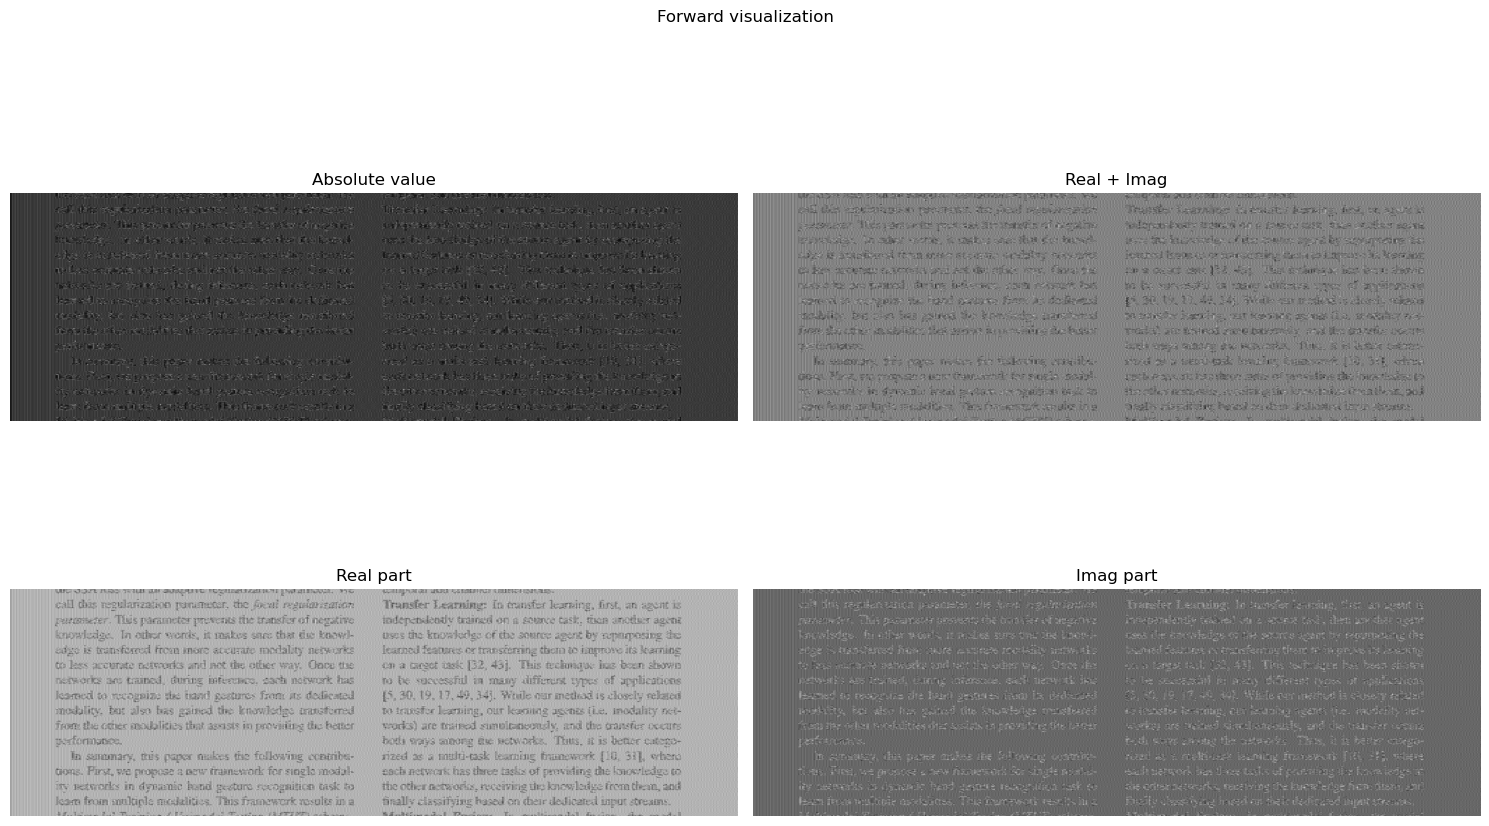

In [74]:
img_out_np = img_out.numpy()

fig, ax = plt.subplots(2,2, figsize=(15,10), sharex=True, sharey=True)
plt.suptitle("Forward visualization")
ax[0,0].imshow(np.abs(img_out_np), cmap='gray'), ax[0,0].set_title("Absolute value"), ax[0,0].axis('off')
ax[0,1].imshow(img_out_np.real + img_out_np.imag, cmap='gray'), ax[0,1].set_title("Real + Imag"), ax[0,1].axis('off')
ax[1,0].imshow(np.real(img_out_np), cmap='gray'), ax[1,0].set_title("Real part"), ax[1,0].axis('off')
ax[1,1].imshow(np.imag(img_out_np), cmap='gray'), ax[1,1].set_title("Imag part"), ax[1,1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Run this when using grad
suma = img_out.sum()
print(suma.backward())